In [1]:
# Specifically for Google Colaboratory
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [2]:
!unzip "./gdrive/My Drive/itu courses/DL2020/Copy of A_05_Part_02_Dataset.zip"
#this unzips data in Google Colaboratory

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

In [0]:
#!unzip "./gdrive/My Drive/itu courses/DL2020/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive/itu courses/DL2020"
#this unzips data in google drive

In [0]:
#import gdown
#url = 'https://drive.google.com/a/itu.edu.pk/uc?id=1-HQQciKYfwAO3oH7ci6zhg45DduvkpnK&export=download'

#gdown.download(url,'Assignment05.zip', quiet=False)



Permission denied: https://drive.google.com/a/itu.edu.pk/uc?id=1-HQQciKYfwAO3oH7ci6zhg45DduvkpnK&export=download
Maybe you need to change permission over 'Anyone with the link'?


### Transfer Learning
### Fine-tuning VGG16 on COVID19 dataset
In this we will learn how to fine-tune a pre-trained network on a new dataset.
We will perform the following steps:
1. Load and normalizing the COVID19 dataset
2. Load pre-trained VGG-16 
3. Remove top layers (fully connected layers)
4. Freeze the network
4. Add new layers (classifier)
5. Train the network
6. Test on test data

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score


### Load Dataset usign torchvision image loader

In [0]:
data_dir = 'A_05_Part_02_Dataset'

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(5),
                                       transforms.RandomResizedCrop(224, scale = (0.9,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(230),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(230),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=val_transforms)
test_data = datasets.ImageFolder(data_dir + '/test1', transform=test_transforms)#create a folder Test1 and move test folder into test1

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=63, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_data, batch_size=63, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=63, shuffle=True, num_workers=4)

print("Classes: ")
class_names = train_data.classes
numberOfClasses = len(class_names)
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
inputs, classes = next(iter(trainloader))

In [44]:
# Sample code for generating one hot encoding
print(classes.view(-1,1))
print(classes.size()[0])
print(numberOfClasses)

def oneHotEncodingOfBatchLabels(batchLabels, numOfClasses):
  onehot = torch.FloatTensor(batchLabels.size()[0], numOfClasses)
  onehot.zero_()
  onehot.scatter_(1, batchLabels.view(-1,1), 1)
  return onehot

encoded = oneHotEncodingOfBatchLabels(classes, numberOfClasses)
print(encoded)

tensor([[2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [2],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [2],
        [1],
        [2],
        [2],
        [1],
        [0],
        [2],
        [1],
        [2],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [2],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [2],
        [2]])
63
3
tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


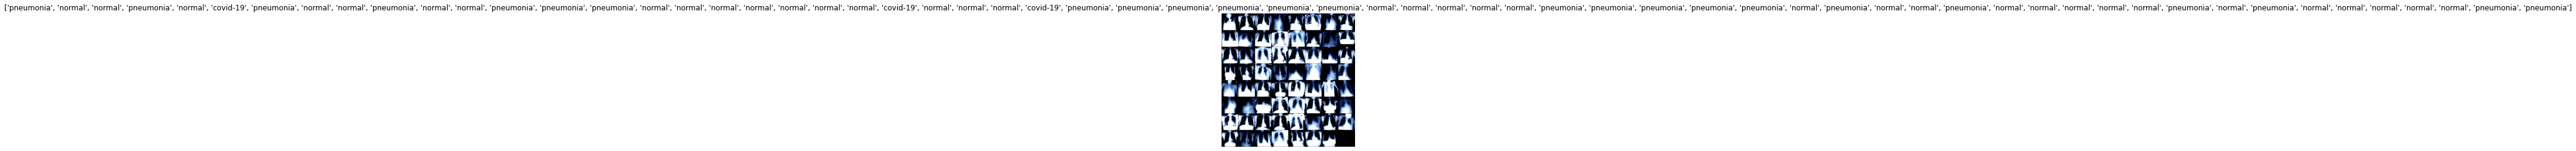

tensor([2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2])

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)


In [0]:
numNeurons1 = 1024 
numNeurons2 = 256 


In [23]:
# Performance Metrics
from sklearn import metrics

def multilabelConfusionMatrix(y_pred, y_true):
  # Multilabel Confusion Matrix
  # Each column represents different class
  # for multilabel, for each class:
  # [[true negative     false positive],
  #  [false negative     true positive]]
  return metrics.multilabel_confusion_matrix(y_true, y_pred)

y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])
print(metrics.multilabel_confusion_matrix(y_true, y_pred))

# Accuracy for multilabel averaged over samples
# Jaccard similarity coefficient score
# Each column represents different class

print(metrics.jaccard_score(y_true[0], y_pred[0]))
print(metrics.jaccard_score(y_true[1], y_pred[1]))
print(metrics.jaccard_score(y_true, y_pred, average='samples'))

# Precesion, Recall, F1Score
print('Precision:')
print(metrics.precision_score(y_true[0], y_pred[0]))
print(metrics.precision_score(y_true[1], y_pred[1]))
precAveragedOnSample = metrics.precision_score(y_true, y_pred, average='samples') 
print(prec)

print('Recall:')
print(metrics.recall_score(y_true[0], y_pred[0]))
print(metrics.recall_score(y_true[1], y_pred[1]))
recallAveragedOnSample = metrics.recall_score(y_true, y_pred, average='samples')
print(recall)

print('F1 Score:')
print(metrics.f1_score(y_true[0], y_pred[0]))
print(metrics.f1_score(y_true[1], y_pred[1]))
print(metrics.f1_score(y_true, y_pred, average='samples'))
f1score = (2 * precAveragedOnSample * recallAveragedOnSample) / (precAveragedOnSample+recallAveragedOnSample) # we are using this F1Score
print(f1score) #we are using this F1Score

[[[0 1]
  [0 1]]

 [[0 0]
  [1 1]]

 [[1 0]
  [0 1]]]
0.6666666666666666
0.5
0.5833333333333333
Precision:
0.6666666666666666
1.0
0.8333333333333333
Recall:
1.0
0.5
0.75
F1 Score:
0.8
0.6666666666666666
0.7333333333333334
0.7894736842105263


### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
print(vgg16.classifier[3])

Linear(in_features=4096, out_features=4096, bias=True)


### Removing Last Layer

In [0]:
num_featuresFCInput = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove all FC layers
print(features)

[]


### Adding New Layer

In [0]:
features.extend([nn.Linear(num_featuresFCInput, numNeurons1)])
features.extend([nn.ReLU(True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(numNeurons1, numNeurons2)])
features.extend([nn.ReLU(True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(numNeurons2, len(class_names))])

In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Resnet

In [0]:
# Load the pretrained model from pytorch

resnet18 = models.resnet18(pretrained=True)
print(resnet18)
#print('Output Layer of resnet18 : ', resnet18.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
  param.require_grad = False

In [0]:
# Replacing fc layer
num_featuresFCInputResnet = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_featuresFCInputResnet, numNeurons),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(numNeurons, len(class_names))
    )
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
resnet18.fc.requires_grad_=True

In [0]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
def feedForwardEval(model, loader, device):
  model.eval()
  correct = 0
  total = 0
  pred = []
  lab = []
  running_loss = 0.0
  counter = 0

  with torch.no_grad():
    for data in loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)   #----> compute loss
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      pred.extend(predicted.tolist())
      lab.extend(labels.tolist())
      correct += (predicted == labels).sum().item()
      counter = counter + 1
  running_loss = running_loss / counter
  accuracy = 100 * correct / total
  print('Accuracy of the network on the images: %d %%' % (
      100 * correct / total))
  return pred, lab, total, correct, accuracy, running_loss

In [0]:
# Training
def training(model, optimizer, criterion, Epochs, trainloader, valloader, valCalcGap, filename):
  from tqdm import tqdm
  
  #if you have gpu then you need to convert the network and data to cuda
  #the easiest way is to first check for device and then convert network and data to device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  
  model.train()
  epochNum = []
  trainAccurList = []
  valAccurList = []
  trainLossList = []
  valLossList = []
    
  for epoch in range(Epochs): 
    # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
      # get the inputs
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
      # because PyTorch accumulates the gradients on subsequent backward passes. 
      # This is convenient while training RNNs. 
      # So, the default action is to accumulate the gradients on every loss.backward() call
      
      # forward + backward + optimize
      outputs = model(inputs)               #----> forward pass
      loss = criterion(outputs, labels)   #----> compute loss
      loss.backward()                     #----> backward pass
      optimizer.step()                    #----> weights update
      
      # print statistics
      running_loss += loss.item()
      
      pbar.set_description(
          'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, i * len(inputs), len(trainloader.dataset),
              100. * i / len(trainloader),
              loss.data.item()))

    #accuracy measure after epoch
    #validation accuracy
    if epoch%valCalcGap == 0:
      model.eval()
      trainpred, trainlabel, traintotal, traincorrect, trainaccuracy, trainLoss = feedForwardEval(model, trainloader,device)
      valpred, vallabel, valtotal, valcorrect, valaccuracy, valLoss = feedForwardEval(model, valloader,device)
      epochNum.append(epoch+1)
      trainAccurList.append(trainaccuracy)
      valAccurList.append(valaccuracy)
      trainLossList.append(trainLoss)
      valLossList.append(valLoss)
      model.train()

    #torch.save(model.state_dict(), 'vgg16_ft.pth')
    torch.save(model.state_dict(), filename)
    
  print('Finished Training')
  return epochNum, trainAccurList, valAccurList, trainLossList, valLossList

In [0]:
epochNum, trainAccurList, valAccurList, trainLossList, valLossList = training(resnet18, optimizer, criterion, Epochs, trainloader, valloader, 1, 'resnet1801.pth')

Train Epoch: 0 [11925/12000 (99%)]	Loss: 0.113494: : 160it [03:43,  1.40s/it]


Accuracy of the network on the images: 92 %
Accuracy of the network on the images: 89 %


Train Epoch: 1 [11925/12000 (99%)]	Loss: 0.141156: : 160it [03:42,  1.39s/it]


In [0]:
epochNum

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [0]:
trainAccurList

[90.51666666666667,
 92.56666666666666,
 93.15833333333333,
 93.95833333333333,
 94.78333333333333,
 95.15833333333333,
 95.85,
 95.24166666666666,
 96.18333333333334,
 95.69166666666666]

In [0]:
valAccurList

[87.93333333333334,
 89.53333333333333,
 89.86666666666666,
 89.86666666666666,
 91.2,
 91.0,
 91.46666666666667,
 90.6,
 90.6,
 89.66666666666667]

In [0]:
trainLossList

[0.24402906062702337,
 0.19449902344495057,
 0.1786322238544623,
 0.1599834465732177,
 0.13912723638738195,
 0.1296608679307004,
 0.11684010443277656,
 0.12727847304195167,
 0.10435449654857318,
 0.1118866595129172]

In [0]:
valLossList

[0.30519938667615254,
 0.256806476910909,
 0.2613937715689341,
 0.25343074401219684,
 0.23952918946743013,
 0.24627847969532013,
 0.24750110904375713,
 0.2547630459070206,
 0.25944608946641284,
 0.27441105544567107]

### Loss fucntion and optimizer

In [0]:
# Setting for VGG
Epochs = 20
valCalGap = 1
criterion = nn.BCEWithLogitsLoss()
vggOptimizer = optim.SGD(vgg16.parameters(), lr=0.002, momentum=0.9)
fileName = 'vgg16_entire.pth'

### Training

In [0]:
epochNum, trainAccurList, valAccurList, trainLossList, valLossList = training(vgg16, vggOptimizer, criterion, Epochs, trainloader, valloader, valCalGap, fileName)




0it [00:00, ?it/s]


Train Epoch: 0 [0/12000 (0%)]	Loss: 0.107725: : 0it [00:10, ?it/s]


Train Epoch: 0 [0/12000 (0%)]	Loss: 0.107725: : 1it [00:10, 10.78s/it]


Train Epoch: 0 [75/12000 (1%)]	Loss: 0.076667: : 1it [00:11, 10.78s/it]


Train Epoch: 0 [75/12000 (1%)]	Loss: 0.076667: : 2it [00:11,  7.74s/it]


Train Epoch: 0 [150/12000 (1%)]	Loss: 0.053232: : 2it [00:12,  7.74s/it]


Train Epoch: 0 [150/12000 (1%)]	Loss: 0.053232: : 3it [00:12,  5.64s/it]


Train Epoch: 0 [225/12000 (2%)]	Loss: 0.151136: : 3it [00:12,  5.64s/it]


Train Epoch: 0 [225/12000 (2%)]	Loss: 0.151136: : 4it [00:12,  4.14s/it]


Train Epoch: 0 [300/12000 (2%)]	Loss: 0.065958: : 4it [00:13,  4.14s/it]


Train Epoch: 0 [300/12000 (2%)]	Loss: 0.065958: : 5it [00:13,  3.11s/it]


Train Epoch: 0 [375/12000 (3%)]	Loss: 0.021884: : 5it [00:14,  3.11s/it]


Train Epoch: 0 [375/12000 (3%)]	Loss: 0.021884: : 6it [00:14,  2.38s/it]


Train Epoch: 0 [450/12000 (4%)]	Loss: 0.111547: : 6it [00:14,  2.38s/it]


Train Epoch

Accuracy of the network on the test images: 97 %
Accuracy of the network on the test images: 91 %





0it [00:00, ?it/s]


Train Epoch: 1 [0/12000 (0%)]	Loss: 0.062734: : 0it [00:11, ?it/s]


Train Epoch: 1 [0/12000 (0%)]	Loss: 0.062734: : 1it [00:11, 11.78s/it]


Train Epoch: 1 [75/12000 (1%)]	Loss: 0.133303: : 1it [00:12, 11.78s/it]


Train Epoch: 1 [75/12000 (1%)]	Loss: 0.133303: : 2it [00:12,  8.45s/it]


Train Epoch: 1 [150/12000 (1%)]	Loss: 0.276344: : 2it [00:13,  8.45s/it]


Train Epoch: 1 [150/12000 (1%)]	Loss: 0.276344: : 3it [00:13,  6.14s/it]


Train Epoch: 1 [225/12000 (2%)]	Loss: 0.056158: : 3it [00:14,  6.14s/it]


Train Epoch: 1 [225/12000 (2%)]	Loss: 0.056158: : 4it [00:14,  4.61s/it]


Train Epoch: 1 [300/12000 (2%)]	Loss: 0.075406: : 4it [00:14,  4.61s/it]


Train Epoch: 1 [300/12000 (2%)]	Loss: 0.075406: : 5it [00:14,  3.44s/it]


Train Epoch: 1 [375/12000 (3%)]	Loss: 0.137443: : 5it [00:15,  3.44s/it]


Train Epoch: 1 [375/12000 (3%)]	Loss: 0.137443: : 6it [00:15,  2.60s/it]


Train Epoch: 1 [450/12000 (4%)]	Loss: 0.067365: : 6it [00:16,  2.60s/it]


Train Epoch

Accuracy of the network on the test images: 96 %
Accuracy of the network on the test images: 91 %





0it [00:00, ?it/s]


Train Epoch: 2 [0/12000 (0%)]	Loss: 0.040051: : 0it [00:11, ?it/s]


Train Epoch: 2 [0/12000 (0%)]	Loss: 0.040051: : 1it [00:11, 11.61s/it]


Train Epoch: 2 [75/12000 (1%)]	Loss: 0.116459: : 1it [00:12, 11.61s/it]


Train Epoch: 2 [75/12000 (1%)]	Loss: 0.116459: : 2it [00:12,  8.32s/it]


Train Epoch: 2 [150/12000 (1%)]	Loss: 0.048899: : 2it [00:12,  8.32s/it]


Train Epoch: 2 [150/12000 (1%)]	Loss: 0.048899: : 3it [00:12,  6.04s/it]


Train Epoch: 2 [225/12000 (2%)]	Loss: 0.117594: : 3it [00:13,  6.04s/it]


Train Epoch: 2 [225/12000 (2%)]	Loss: 0.117594: : 4it [00:13,  4.42s/it]


Train Epoch: 2 [300/12000 (2%)]	Loss: 0.045130: : 4it [00:14,  4.42s/it]


Train Epoch: 2 [300/12000 (2%)]	Loss: 0.045130: : 5it [00:14,  3.31s/it]


Train Epoch: 2 [375/12000 (3%)]	Loss: 0.132299: : 5it [00:14,  3.31s/it]


Train Epoch: 2 [375/12000 (3%)]	Loss: 0.132299: : 6it [00:14,  2.51s/it]


Train Epoch: 2 [450/12000 (4%)]	Loss: 0.102307: : 6it [00:15,  2.51s/it]


Train Epoch

Accuracy of the network on the test images: 97 %
Accuracy of the network on the test images: 91 %





0it [00:00, ?it/s]


Train Epoch: 3 [0/12000 (0%)]	Loss: 0.039257: : 0it [00:12, ?it/s]


Train Epoch: 3 [0/12000 (0%)]	Loss: 0.039257: : 1it [00:12, 12.59s/it]


Train Epoch: 3 [75/12000 (1%)]	Loss: 0.018715: : 1it [00:13, 12.59s/it]


Train Epoch: 3 [75/12000 (1%)]	Loss: 0.018715: : 2it [00:13,  9.01s/it]


Train Epoch: 3 [150/12000 (1%)]	Loss: 0.042482: : 2it [00:13,  9.01s/it]


Train Epoch: 3 [150/12000 (1%)]	Loss: 0.042482: : 3it [00:13,  6.52s/it]


Train Epoch: 3 [225/12000 (2%)]	Loss: 0.081406: : 3it [00:14,  6.52s/it]


Train Epoch: 3 [225/12000 (2%)]	Loss: 0.081406: : 4it [00:14,  4.76s/it]


Train Epoch: 3 [300/12000 (2%)]	Loss: 0.085547: : 4it [00:15,  4.76s/it]


Train Epoch: 3 [300/12000 (2%)]	Loss: 0.085547: : 5it [00:15,  3.55s/it]


Train Epoch: 3 [375/12000 (3%)]	Loss: 0.033372: : 5it [00:15,  3.55s/it]


Train Epoch: 3 [375/12000 (3%)]	Loss: 0.033372: : 6it [00:16,  2.68s/it]


Train Epoch: 3 [450/12000 (4%)]	Loss: 0.118478: : 6it [00:16,  2.68s/it]


Train Epoch

Accuracy of the network on the test images: 97 %
Accuracy of the network on the test images: 92 %





0it [00:00, ?it/s]


Train Epoch: 4 [0/12000 (0%)]	Loss: 0.039750: : 0it [00:11, ?it/s]


Train Epoch: 4 [0/12000 (0%)]	Loss: 0.039750: : 1it [00:11, 11.09s/it]


Train Epoch: 4 [75/12000 (1%)]	Loss: 0.055728: : 1it [00:11, 11.09s/it]


Train Epoch: 4 [75/12000 (1%)]	Loss: 0.055728: : 2it [00:11,  7.96s/it]


Train Epoch: 4 [150/12000 (1%)]	Loss: 0.070034: : 2it [00:12,  7.96s/it]


Train Epoch: 4 [150/12000 (1%)]	Loss: 0.070034: : 3it [00:12,  5.78s/it]


Train Epoch: 4 [225/12000 (2%)]	Loss: 0.051988: : 3it [00:13,  5.78s/it]


Train Epoch: 4 [225/12000 (2%)]	Loss: 0.051988: : 4it [00:13,  4.24s/it]


Train Epoch: 4 [300/12000 (2%)]	Loss: 0.017966: : 4it [00:13,  4.24s/it]


Train Epoch: 4 [300/12000 (2%)]	Loss: 0.017966: : 5it [00:13,  3.19s/it]


Train Epoch: 4 [375/12000 (3%)]	Loss: 0.064094: : 5it [00:14,  3.19s/it]


Train Epoch: 4 [375/12000 (3%)]	Loss: 0.064094: : 6it [00:14,  2.42s/it]


Train Epoch: 4 [450/12000 (4%)]	Loss: 0.082110: : 6it [00:15,  2.42s/it]


Train Epoch

Accuracy of the network on the test images: 97 %
Accuracy of the network on the test images: 90 %





0it [00:00, ?it/s]


Train Epoch: 5 [0/12000 (0%)]	Loss: 0.073396: : 0it [00:11, ?it/s]


Train Epoch: 5 [0/12000 (0%)]	Loss: 0.073396: : 1it [00:11, 11.35s/it]


Train Epoch: 5 [75/12000 (1%)]	Loss: 0.026267: : 1it [00:12, 11.35s/it]


Train Epoch: 5 [75/12000 (1%)]	Loss: 0.026267: : 2it [00:12,  8.15s/it]


Train Epoch: 5 [150/12000 (1%)]	Loss: 0.026493: : 2it [00:12,  8.15s/it]


Train Epoch: 5 [150/12000 (1%)]	Loss: 0.026493: : 3it [00:12,  5.91s/it]


Train Epoch: 5 [225/12000 (2%)]	Loss: 0.050708: : 3it [00:13,  5.91s/it]


Train Epoch: 5 [225/12000 (2%)]	Loss: 0.050708: : 4it [00:13,  4.33s/it]


Train Epoch: 5 [300/12000 (2%)]	Loss: 0.083744: : 4it [00:14,  4.33s/it]


Train Epoch: 5 [300/12000 (2%)]	Loss: 0.083744: : 5it [00:14,  3.25s/it]


Train Epoch: 5 [375/12000 (3%)]	Loss: 0.031930: : 5it [00:14,  3.25s/it]


Train Epoch: 5 [375/12000 (3%)]	Loss: 0.031930: : 6it [00:14,  2.47s/it]


Train Epoch: 5 [450/12000 (4%)]	Loss: 0.039341: : 6it [00:15,  2.47s/it]


Train Epoch

Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 92 %





0it [00:00, ?it/s]


Train Epoch: 6 [0/12000 (0%)]	Loss: 0.026352: : 0it [00:11, ?it/s]


Train Epoch: 6 [0/12000 (0%)]	Loss: 0.026352: : 1it [00:11, 11.17s/it]


Train Epoch: 6 [75/12000 (1%)]	Loss: 0.041977: : 1it [00:11, 11.17s/it]


Train Epoch: 6 [75/12000 (1%)]	Loss: 0.041977: : 2it [00:11,  8.07s/it]


Train Epoch: 6 [150/12000 (1%)]	Loss: 0.005094: : 2it [00:12,  8.07s/it]


Train Epoch: 6 [150/12000 (1%)]	Loss: 0.005094: : 3it [00:12,  5.86s/it]


Train Epoch: 6 [225/12000 (2%)]	Loss: 0.003968: : 3it [00:13,  5.86s/it]


Train Epoch: 6 [225/12000 (2%)]	Loss: 0.003968: : 4it [00:13,  4.30s/it]


Train Epoch: 6 [300/12000 (2%)]	Loss: 0.129590: : 4it [00:14,  4.30s/it]


Train Epoch: 6 [300/12000 (2%)]	Loss: 0.129590: : 5it [00:14,  3.23s/it]


Train Epoch: 6 [375/12000 (3%)]	Loss: 0.025526: : 5it [00:14,  3.23s/it]


Train Epoch: 6 [375/12000 (3%)]	Loss: 0.025526: : 6it [00:14,  2.46s/it]


Train Epoch: 6 [450/12000 (4%)]	Loss: 0.019250: : 6it [00:15,  2.46s/it]


Train Epoch

Accuracy of the network on the test images: 98 %
Accuracy of the network on the test images: 91 %





0it [00:00, ?it/s]


Train Epoch: 7 [0/12000 (0%)]	Loss: 0.027085: : 0it [00:11, ?it/s]


Train Epoch: 7 [0/12000 (0%)]	Loss: 0.027085: : 1it [00:11, 11.16s/it]


Train Epoch: 7 [75/12000 (1%)]	Loss: 0.044177: : 1it [00:11, 11.16s/it]


Train Epoch: 7 [75/12000 (1%)]	Loss: 0.044177: : 2it [00:11,  8.03s/it]


Train Epoch: 7 [150/12000 (1%)]	Loss: 0.020389: : 2it [00:12,  8.03s/it]


Train Epoch: 7 [150/12000 (1%)]	Loss: 0.020389: : 3it [00:12,  5.84s/it]


Train Epoch: 7 [225/12000 (2%)]	Loss: 0.088216: : 3it [00:13,  5.84s/it]


Train Epoch: 7 [225/12000 (2%)]	Loss: 0.088216: : 4it [00:13,  4.29s/it]


Train Epoch: 7 [300/12000 (2%)]	Loss: 0.068354: : 4it [00:14,  4.29s/it]


Train Epoch: 7 [300/12000 (2%)]	Loss: 0.068354: : 5it [00:14,  3.22s/it]


Train Epoch: 7 [375/12000 (3%)]	Loss: 0.030342: : 5it [00:14,  3.22s/it]


Train Epoch: 7 [375/12000 (3%)]	Loss: 0.030342: : 6it [00:14,  2.45s/it]


Train Epoch: 7 [450/12000 (4%)]	Loss: 0.051966: : 6it [00:15,  2.45s/it]


Train Epoch

Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 90 %





0it [00:00, ?it/s]


Train Epoch: 8 [0/12000 (0%)]	Loss: 0.022478: : 0it [00:10, ?it/s]


Train Epoch: 8 [0/12000 (0%)]	Loss: 0.022478: : 1it [00:10, 10.84s/it]


Train Epoch: 8 [75/12000 (1%)]	Loss: 0.025593: : 1it [00:11, 10.84s/it]


Train Epoch: 8 [75/12000 (1%)]	Loss: 0.025593: : 2it [00:11,  7.79s/it]


Train Epoch: 8 [150/12000 (1%)]	Loss: 0.013812: : 2it [00:12,  7.79s/it]


Train Epoch: 8 [150/12000 (1%)]	Loss: 0.013812: : 3it [00:12,  5.67s/it]


Train Epoch: 8 [225/12000 (2%)]	Loss: 0.051142: : 3it [00:12,  5.67s/it]


Train Epoch: 8 [225/12000 (2%)]	Loss: 0.051142: : 4it [00:12,  4.16s/it]


Train Epoch: 8 [300/12000 (2%)]	Loss: 0.037008: : 4it [00:13,  4.16s/it]


Train Epoch: 8 [300/12000 (2%)]	Loss: 0.037008: : 5it [00:13,  3.13s/it]


Train Epoch: 8 [375/12000 (3%)]	Loss: 0.024232: : 5it [00:14,  3.13s/it]


Train Epoch: 8 [375/12000 (3%)]	Loss: 0.024232: : 6it [00:14,  2.38s/it]


Train Epoch: 8 [450/12000 (4%)]	Loss: 0.053123: : 6it [00:14,  2.38s/it]


Train Epoch

Accuracy of the network on the test images: 98 %
Accuracy of the network on the test images: 91 %





0it [00:00, ?it/s]


Train Epoch: 9 [0/12000 (0%)]	Loss: 0.010045: : 0it [00:11, ?it/s]


Train Epoch: 9 [0/12000 (0%)]	Loss: 0.010045: : 1it [00:11, 11.62s/it]


Train Epoch: 9 [75/12000 (1%)]	Loss: 0.048427: : 1it [00:12, 11.62s/it]


Train Epoch: 9 [75/12000 (1%)]	Loss: 0.048427: : 2it [00:12,  8.32s/it]


Train Epoch: 9 [150/12000 (1%)]	Loss: 0.036867: : 2it [00:12,  8.32s/it]


Train Epoch: 9 [150/12000 (1%)]	Loss: 0.036867: : 3it [00:12,  6.05s/it]


Train Epoch: 9 [225/12000 (2%)]	Loss: 0.011163: : 3it [00:13,  6.05s/it]


Train Epoch: 9 [225/12000 (2%)]	Loss: 0.011163: : 4it [00:13,  4.43s/it]


Train Epoch: 9 [300/12000 (2%)]	Loss: 0.022138: : 4it [00:14,  4.43s/it]


Train Epoch: 9 [300/12000 (2%)]	Loss: 0.022138: : 5it [00:14,  3.33s/it]


Train Epoch: 9 [375/12000 (3%)]	Loss: 0.021036: : 5it [00:15,  3.33s/it]


Train Epoch: 9 [375/12000 (3%)]	Loss: 0.021036: : 6it [00:15,  2.53s/it]


Train Epoch: 9 [450/12000 (4%)]	Loss: 0.012013: : 6it [00:15,  2.53s/it]


Train Epoch

Accuracy of the network on the test images: 99 %
Accuracy of the network on the test images: 90 %
Finished Training


In [0]:
epochNum

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [0]:
trainAccurList

[97.00833333333334,
 96.925,
 97.41666666666667,
 97.5,
 97.71666666666667,
 99.3,
 98.96666666666667,
 99.06666666666666,
 98.875,
 99.05]

In [0]:
valAccurList

[91.33333333333333,
 91.4,
 91.6,
 92.26666666666667,
 90.86666666666666,
 92.06666666666666,
 91.73333333333333,
 90.86666666666666,
 91.73333333333333,
 90.13333333333334]

In [0]:
trainLossList

[0.0853580262628384,
 0.07845763189252467,
 0.06779634824488312,
 0.06064348857908044,
 0.05931731718737865,
 0.02376282762561459,
 0.028077382961055265,
 0.028074051690055057,
 0.030035519177181412,
 0.024935009546607035]

In [0]:
valLossList

[0.2644068870693445,
 0.2396010011434555,
 0.26549047902226447,
 0.28373014032840727,
 0.31372594349086286,
 0.25427181012928485,
 0.3148753892630339,
 0.3137945272028446,
 0.3840449873358011,
 0.40801035761833193]

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


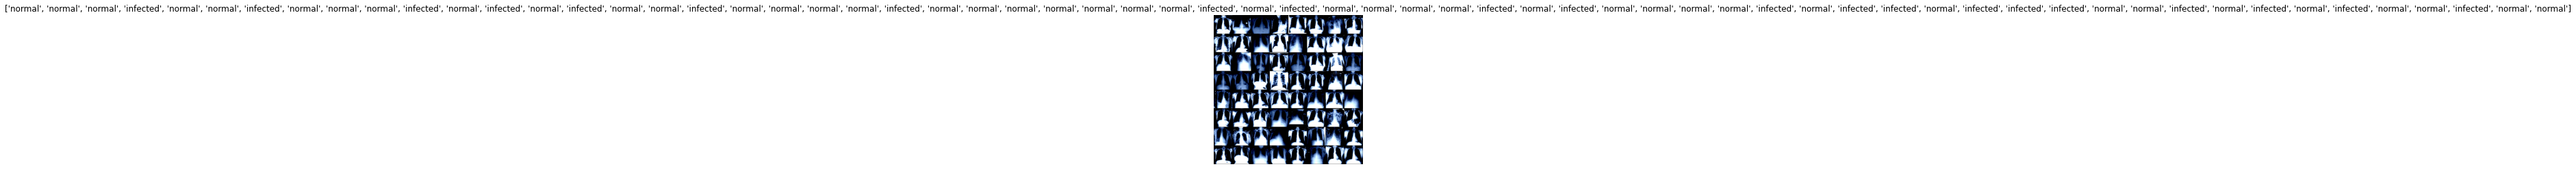

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected normal normal normal normal infected normal infected normal normal infected infected infected normal normal infected normal normal normal infected normal normal normal normal infected infected infected normal normal normal infected infected normal normal normal normal normal normal normal infected infected normal normal normal normal normal normal infected normal normal normal infected normal infected normal infected infected infected normal normal normal normal
Ground Truth:  infected normal infected normal normal normal normal infected normal infected normal normal infected infected infected normal normal infected normal normal normal infected normal normal normal normal infected infected infected infected normal normal infected infected normal infected normal normal normal normal normal infected infected normal normal normal normal normal normal infected normal normal normal infected normal infected normal infected infected infected normal normal

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 96 %


In [0]:
#torch.save(vgg16.state_dict(), "./gdrive/My Drive/itu courses/DL2020/vgg16_ft.pth")



In [0]:
trainAccurList

[94.65,
 67.39166666666667,
 95.525,
 96.33333333333333,
 96.825,
 95.53333333333333,
 97.775,
 97.975,
 97.50833333333334,
 98.59166666666667]

In [0]:
modelForEval = vgg16

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainpred, trainlab, traintotal, traincorrect, trainaccuracy, trainloss = feedForwardEval(modelForEval,trainloader,device)

Accuracy of the network on the test images: 99 %


In [0]:
print(accuracy_score(trainlab, trainpred))
print(f1_score(trainlab, trainpred))
print(confusion_matrix(trainlab, trainpred))
print(classification_report(trainlab, trainpred))

0.99125
0.9925884096844779
[[4864   55]
 [  50 7031]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4919
           1       0.99      0.99      0.99      7081

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
valpred, vallab, valtotal, valcorrect, valaccuracy, valloss = feedForwardEval(modelForEval,valloader,device)

Accuracy of the network on the test images: 90 %


In [0]:
print(accuracy_score(vallab, valpred))
print(f1_score(vallab, valpred))
print(confusion_matrix(vallab, valpred))
print(classification_report(vallab, valpred))

0.9013333333333333
0.9165727170236754
[[539  76]
 [ 72 813]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       615
           1       0.91      0.92      0.92       885

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testpred, testlab, total, testcorrect, testaccuracy, testloss = feedForwardEval(modelForEval,testloader,device)

Accuracy of the network on the test images: 96 %


In [0]:
print(accuracy_score(testlab, testpred))
print(f1_score(testlab, testpred))
print(confusion_matrix(testlab, testpred))
print(classification_report(testlab, testpred))

0.9673333333333334
0.9724254361283061
[[587  28]
 [ 21 864]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       615
           1       0.97      0.98      0.97       885

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


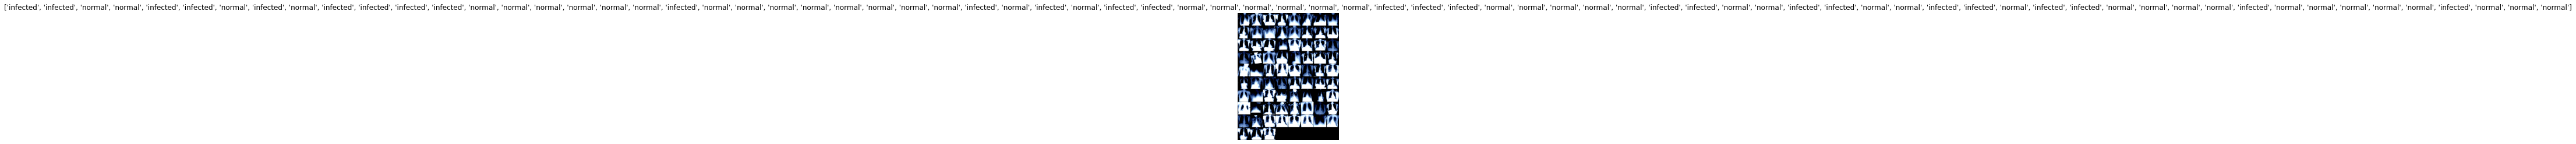

tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1], device='cuda:0')
tensor([[1.0000e+00, 8.1849e-07],
        [1.0000e+00, 2.1406e-07],
        [2.9242e-08, 1.0000e+00],
        [6.4014e-02, 9.3599e-01],
        [9.9967e-01, 3.3214e-04],
        [1.0000e+00, 2.1963e-18],
        [1.4817e-02, 9.8518e-01],
        [8.9499e-03, 9.9105e-01],
        [4.8403e-08, 1.0000e+00],
        [9.9963e-01, 3.7028e-04],
        [1.0000e+00, 6.6682e-10],
        [9.9813e-01, 1.8700e-03],
        [9.9410e-01, 5.9047e-03],
        [5.1972e-04, 9.9948e-01],
        [4.6877e-03, 9.9531e-01],
        [1.2981e-07, 1.0000e+00],
        [2.3576e-05, 9.9998e-01],
        [1.6781e-03, 9.9832e-01],
        [1.3678e-07, 1.0000e+00],
        [9.9988e-01, 1.2007e-04],
        [4.3324e-03, 9.9567e-01],
        [4.

NameError: ignored

In [0]:
model = vgg16
loader = testloader
model.eval()
correct = 0
total = 0
pred = []
lab = []
running_loss = 0.0
counter = 0

dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
loss = criterion(outputs, labels)   #----> compute loss
running_loss += loss.item()
_, predicted = torch.max(outputs.data, 1)

total += labels.size(0)
pred.extend(predicted.tolist())
lab.extend(labels.tolist())

classProb = torch.nn.functional.softmax(outputs.data, 1)
print(predicted)
print(classProb)

      


In [0]:
print(outputs)
accu = (predicted == labels)
print(accu)
indiceWhereFailed = (accu == 0).nonzero()
print(indiceWhereFailed)

indiceWhereSuccess = (accu).nonzero() 
print(indiceWhereSuccess)


tensor([[  7.1381,  -6.8777],
        [  8.4232,  -6.9339],
        [ -8.6681,   8.6796],
        [ -1.2015,   1.4810],
        [  4.5480,  -3.4616],
        [ 21.5803, -19.0794],
        [ -2.0709,   2.1261],
        [ -2.4108,   2.2963],
        [ -8.4967,   8.3470],
        [  4.0945,  -3.8064],
        [ 11.2301,  -9.8984],
        [  3.1906,  -3.0893],
        [  2.7754,  -2.3507],
        [ -3.6183,   3.9434],
        [ -2.5158,   2.8423],
        [ -7.9533,   7.9039],
        [ -5.2718,   5.3834],
        [ -3.1762,   3.2122],
        [ -7.9419,   7.8630],
        [  4.8985,  -4.1288],
        [ -2.7664,   2.6709],
        [ -0.0317,   0.3436],
        [ -5.2211,   5.0811],
        [ -7.5434,   7.3948],
        [ -4.3447,   4.3664],
        [ -2.5927,   2.5523],
        [  2.0070,  -1.7106],
        [ -2.6428,   2.6977],
        [  8.2850,  -7.6942],
        [ -5.7470,   5.6608],
        [  7.2555,  -6.7303],
        [ -5.8291,   5.6872],
        [  5.0314,  -4.3957],
        [ 

In [0]:
torch.min((classProb[:,0]) [indiceWhereFailed]) #worst class 0 (infected)
(classProb[:,0]) [indiceWhereFailed]<0.009
indiceWhereFailed[torch.argmin((classProb[:,0]) [indiceWhereFailed])] #worst class 0 (infected)


tensor(0, device='cuda:0')

In [0]:
torch.min((classProb[:,1]) [indiceWhereFailed]) #worst class 1 (normal)
(classProb[:,1]) [indiceWhereFailed]<0.009
indiceWhereFailed[torch.argmin((classProb[:,1]) [indiceWhereFailed])] #worst class 1 (normal)
#(classProb[:,1]) [indiceWhereFailed]


tensor([26], device='cuda:0')

In [0]:
torch.min((classProb[:,1]) [indiceWhereSuccess]) #best class 0 (infected)
(classProb[:,1]) [indiceWhereSuccess]<0.009
indiceWhereSuccess[torch.argmin((classProb[:,1]) [indiceWhereSuccess])] #worst class 0 (infected)


tensor([5], device='cuda:0')

In [0]:
torch.min((classProb[:,0]) [indiceWhereSuccess]) #best class 1 (normal)
(classProb[:,0]) [indiceWhereSuccess]<0.009
indiceWhereSuccess[torch.argmin((classProb[:,0]) [indiceWhereSuccess])] #best class 1 (normal)


tensor([58], device='cuda:0')

In [0]:
indiceWhereSuccess[torch.argmin((classProb[:,0]) [indiceWhereSuccess])]

tensor([58], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Best Case from Normal class')

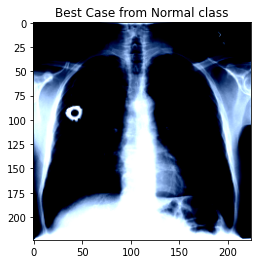

In [0]:
#images[58].cpu().to(torch.device("cpu"))
plt.imshow(images[58].cpu().permute(1, 2, 0))
plt.title("Best Case from Normal class")


In [0]:
(classProb) [indiceWhereSuccess]

tensor([[[1.0000e+00, 8.1849e-07]],

        [[1.0000e+00, 2.1406e-07]],

        [[2.9242e-08, 1.0000e+00]],

        [[6.4014e-02, 9.3599e-01]],

        [[9.9967e-01, 3.3214e-04]],

        [[1.0000e+00, 2.1963e-18]],

        [[1.4817e-02, 9.8518e-01]],

        [[4.8403e-08, 1.0000e+00]],

        [[9.9963e-01, 3.7028e-04]],

        [[1.0000e+00, 6.6682e-10]],

        [[9.9813e-01, 1.8700e-03]],

        [[9.9410e-01, 5.9047e-03]],

        [[5.1972e-04, 9.9948e-01]],

        [[4.6877e-03, 9.9531e-01]],

        [[1.2981e-07, 1.0000e+00]],

        [[2.3576e-05, 9.9998e-01]],

        [[1.6781e-03, 9.9832e-01]],

        [[1.3678e-07, 1.0000e+00]],

        [[9.9988e-01, 1.2007e-04]],

        [[4.3324e-03, 9.9567e-01]],

        [[4.0728e-01, 5.9272e-01]],

        [[3.3560e-05, 9.9997e-01]],

        [[3.2541e-07, 1.0000e+00]],

        [[1.6471e-04, 9.9984e-01]],

        [[5.7948e-03, 9.9421e-01]],

        [[4.7709e-03, 9.9523e-01]],

        [[1.0000e+00, 1.1490e-07]],

 

In [0]:
class_names

['infected', 'normal']

In [0]:
def feedForwardForBestAndWorst(model, loader, device):
  
  model.eval()
  correct = 0
  total = 0
  pred = []
  lab = []
  running_loss = 0.0
  counter = 0

  with torch.no_grad():
    for data in loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)   #----> compute loss
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      


      total += labels.size(0)
      pred.extend(predicted.tolist())
      lab.extend(labels.tolist())
      

      classProb = torch.nn.functional.softmax(outputs.data, 1)
      print(predicted)
      print(classProb)
      print(output)
      torch.sub
      accu = (predicted == labels)
      print(accu)
      
      indiceWhereFailed = (accu == 0).nonzero()
      print(indiceWhereFailed)
       
      indiceWhereSuccess = (accu).nonzero() 
      print(indiceWhereSuccess)
      

      correct += (predicted == labels).sum().item()
      counter = counter + 1
  running_loss = running_loss / counter
  accuracy = 100 * correct / total
  print('Accuracy of the network on the images: %d %%' % (
      100 * correct / total))
  return pred, lab, total, correct, accuracy, running_loss

NameError: ignored